In [3]:
import numpy as np
import numpy.linalg as la
import pdb
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [4]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['font.size']=20

### Simple Flory Huggins free energy for the Protein(P)-mRNA(M)-RNA(R) system

The free enrgy expression is:

$f(\phi_P, \phi_R, \phi_M) =  - S(\phi_P, \phi_R, \phi_M) + E(\phi_P, \phi_R, \phi_M)$

$S(\phi_P, \phi_R, \phi_M) = - \Big[ \frac{\phi_P}{N_P} \ln(\phi_P) + \frac{\phi_R}{N_R} \ln(\phi_R) + \frac{\phi_M}{N_M} \ln(\phi_M) + (1-\phi_P-\phi_R-\phi_M)\ln(1-\phi_P-\phi_R-\phi_M) \Big]$

$E(\phi_P, \phi_R, \phi_M) = - \frac{|\epsilon_P|}{2}\phi_P^2 - |\epsilon_{PR}|\phi_P\phi_R -|\epsilon_{PM}|\phi_P\phi_M + \frac{|\epsilon_{RR}|}{2}(\phi_R + \phi_M)^2$

In [1]:
class free_energy_FH_3_comp:
    """
    Class definition for the Flory-Huggins free energy
    
    The expression of the FH free energy of a three component Protein(P)-mRNA(M)-RNA(R) system is given by 
    the above expression
 
    """
    
    def __init__(self, params):
        """
        Function to take in parameters associated with the above free energy functional and initialize class instance
        Parameters: N_P, N_R, N_M, e_P, e_PM, e_PR, e_R
        """
        
        self.N_P = params['N_P']
        self.N_R = params['N_R']
        self.N_M = params['N_M']
        self.e_P = params['e_P']
        self.e_PR = params['e_PR']
        self.e_PM = params['e_PM']
        self.e_R = params['e_R']  
    
    def fe(self, phi_p, phi_r, phi_m):
        """
        Function that returns the free energy of the system at a given point in the concentration space according to the
        above expression
        """
        return (phi_p*np.log(phi_p)/self.N_P + phi_r*np.log(phi_r)/self.N_R + phi_m*np.log(phi_m)/self.N_M 
                + (1-phi_p-phi_r-phi_m)*np.log(1-phi_p-phi_r-phi_m) - 0.5*self.e_P*phi_p**2 - self.e_PR*phi_p*phi_r
                - self.e_PM*phi_p*phi_m + 0.5*self.e_R*(phi_r + phi_m)**2
                )
    
    def mu_p(self, phi_p, phi_r, phi_m):
        """
        Function that returns the chemical potential of the protein
        """
        return ( (1 + np.log(phi_p))/self.N_P - np.log(1-phi_p-phi_r+phi_m) - 1 - self.e_P*phi_p
                    - self.e_PR*phi_r + self.e_PM*phi_m )
    
    def mu_r(self, phi_p, phi_r, phi_m):
        """
        Function that returns the chemical potential of the RNA
        """
        return ( (1 + np.log(phi_r))/self.N_R - np.log(1-phi_p-phi_r+phi_m) - 1 
                    - self.e_PR*phi_p + self.e_R*(phi_r+phi_m) )
    
    def mu_m(self, phi_p, phi_r, phi_m):
        """
        Function that returns the chemical potential of the mRNA
        """
        return ( (1 + np.log(phi_m))/self.N_M - np.log(1-phi_p-phi_r+phi_m) - 1 
                    - self.e_PM*phi_p + self.e_R*(phi_r+phi_m) )
    
    def jacobian(self, phi_p, phi_r, phi_m):
        
        """
        Function that returns the Jacobian matrix of the FH free energy of a three component Protein(P)-mRNA(m)-RNA(R)
        system
        """
        
        jacobian = np.zeros([3,3])
        
        phi_r_total = phi_r + phi_m
        
        jacobian[0,0] = 1/(self.N_P*phi_p) + 1/(1-phi_p-phi_r_total) - self.e_P 
        jacobian[0,1] = jacobian[1,0] =  1/(1-phi_p-phi_r_total) - self.e_PR
        jacobian[0,2] = jacobian[2,0] =  1/(1-phi_p-phi_r_total) - self.e_PM 
        jacobian[1,2] = jacobian[2,1] =  1/(1-phi_p-phi_r_total) + self.e_R
        jacobian[1,1] = 1/(self.N_R*phi_r) + self.e_R
        jacobian[2,2] = 1/(self.N_M*phi_m) + self.e_R
        
        return jacobian      

### Flory Huggins with solvent entropy expansion for Protein(P)-mRNA(M)-RNA(R) system

Refer notes from **20210827 - Equivalence between our LG-Expression and a FH model**

The free energy expression is:

$f(\phi_P, \phi_R, \phi_M) = f_{P}(\phi_P) + f_{R}(\phi_R, \phi_M) + H_{PR}(\phi_P, \phi_R, \phi_M) $

Where,

$f_{P}(\phi_P) = \frac{\phi_p}{N_P} \ln(\phi_P) + (1-\phi_P) \ln(1-\phi_P) - \frac{|\epsilon_P|}{2}\phi_P^2$

$f_R(\phi_R, \phi_M) = \frac{\phi_M}{N_M} \ln(\phi_M) + \frac{\phi_R}{N_R} \ln(\phi_R) + \frac{|\epsilon_R|+1}{2}(\phi_R + \phi_M)^2 $

$ H_{PR}(\phi_P, \phi_R, \phi_M) = - (|\epsilon_{PR}| - 1) \phi_P\phi_R - (|\epsilon_{PM}| - 1) \phi_P\phi_M + 0.5\phi_P(\phi_R + \phi_M)^2 + 0.5\phi_P^2(\phi_R + \phi_M) + 0.5 \phi_P^2(\phi_R + \phi_M)^2 $

Define the following parameters:
- $\chi_P = \frac{|\epsilon_P|}{2}$
- $\chi_{PR} = (|\epsilon_{PR}| - 1)$
- $\rho_R = \frac{|\epsilon_R|+1}{2}$

In [2]:
class free_energy_FH_mod_3_comp:
    """
    Class definition for the Flory-Huggins free energy with expansion for solvent entropy 
    
    The expression of the FH free energy of a three component Protein(P)-mRNA(M)-RNA(R) system is given by 
    the above expression
 
    """
    
    def __init__(self, params):
        """
        Function to take in parameters associated with the above free energy functional and initialize class instance
        Parameters: N_P, N_R, N_M, chi_P, chi_PM, chi_PR, rho_R
        """
        
        self.N_P = params['N_P']
        self.N_R = params['N_R']
        self.N_M = params['N_M']
        self.chi_P = params['chi_P']
        self.chi_PR = params['chi_PR']
        self.chi_PM = params['chi_PM']
        self.rho_R = params['rho_R']  
            
    def fe(self, phi_p, phi_r, phi_m):
        """
        Function that returns the free energy of the system at a given point in the concentration space according to the
        above expression
        """
        phi_total = phi_r + phi_m
        return ( phi_p*np.log(phi_p)/self.N_P + (1-phi_p)*np.log(1-phi_p) - self.chi_P*phi_p**2
                 + phi_r*np.log(phi_r)/self.N_R + phi_m*np.log(phi_m)/self.N_M + self.rho_R*phi_total**2
                 - self.chi_PR*phi_p*phi_r - self.chi_PM*phi_p*phi_m 
                 + 0.5*(phi_p**2*phi_total + phi_p*phi_total**2 + phi_p**2*phi_r**2) )
    
    def mu_p(self, phi_p, phi_r, phi_m):
        """
        Function that returns the chemical potential of the protein
        """
        phi_total = phi_r + phi_m
        return ( (1+np.log(phi_p))/self.N_P - 1 - np.log(1-phi_p) - 2*self.chi_P*phi_p 
                 - self.chi_PR*phi_r -self.chi_PM*phi_m + 0.5*phi_total**2 + phi_p*phi_total + phi_p*phi_total**2 )
    
    def mu_r(self, phi_p, phi_r, phi_m):
        """
        Function that returns the chemical potential of the RNA
        """
        phi_total = phi_r + phi_m
        return ( (1+np.log(phi_r))/self.N_R + 2*self.rho_R*phi_total - self.chi_PR*phi_p + phi_p*phi_total
                 + 0.5*phi_p**2 + phi_p**2*phi_total)
    
    def mu_m(self, phi_p, phi_r, phi_m):
        """
        Function that returns the chemical potential of the mRNA
        """
        phi_total = phi_r + phi_m
        return ( (1+np.log(phi_m))/self.N_M + 2*self.rho_R*phi_total - self.chi_PM*phi_p + phi_p*phi_total
                 + 0.5*phi_p**2 + phi_p**2*phi_total)
    
    def jacobian(self, phi_p, phi_r, phi_m):
        
        """
        Function that returns the Jacobian matrix of the FH free energy of a three component Protein(P)-mRNA(m)-RNA(R)
        system
        """
        
        jacobian = np.zeros([3,3])
        
        phi_r_total = phi_r + phi_m
        
        jacobian[0,0] = 1/(self.N_P*phi_p) + 1/(1-phi_p) - 2*self.chi_P + phi_r_total + phi_r_total**2
        jacobian[0,1] = jacobian[1,0] = phi_p + 2*phi_p*phi_r_total + phi_r_total - self.chi_PR 
        jacobian[0,2] = jacobian[2,0] = phi_p + 2*phi_p*phi_r_total + phi_r_total - self.chi_PM
        jacobian[1,1] = 1/(self.N_R*phi_r) + phi_p + phi_p**2 + 2*self.rho_R
        jacobian[2,2] = 1/(self.N_M*phi_m) + phi_p + phi_p**2 + 2*self.rho_R
        jacobian[1,2] = jacobian[2,1] = phi_p + phi_p**2 + 2*self.rho_R
        
        return jacobian 

### Landau expansion of the free energy functional for the Protein(P)-mRNA(M)-RNA(R) system

The below expression for the free energy of this system is obtained by simply extending the terms that involve RNA to two different species of RNA:

$f(\phi_P, \phi_R, \phi_M) = f_{P}(\phi_P) + f_{R}(\phi_R, \phi_M) + H_{PR}(\phi_P, \phi_R, \phi_M) $

Where,

$f_{P}(\phi_P) = \rho_P(\phi_p-\alpha)^2(\phi_P-\beta)^2$

$f_{R}(\phi_R, \phi_M) = \rho_R(\phi_R + \phi_M)^2$

$H_{PR}(\phi_P, \phi_R, \phi_M) = -\chi_{PR}\phi_P\phi_R - \chi_{PM}\phi_P\phi_M + a \phi_P (\phi_R+\phi_M)^2 + b \phi_P^2 (\phi_R+\phi_M) + c \phi_P^2(\phi_R+\phi_M)^2$


In [5]:
class free_energy_landau_3_comp:
    """
    Class definition for the Landau expansion for free energy
    
    The expression of the Landau free energy of a three component Protein(P)-mRNA(M)-RNA(R) system is given by 
    the above expression
 
    """
    
    def __init__(self, params):
        """
        Function to take in parameters associated with the above free energy functional and initialize class instance
        Parameters: rho_P, alpha, beta, rho_R, chi_PM, chi_PR, a, b, c
        """
        
        self.rho_p = params['rho_p'] 
        self.alpha = params['alpha'] 
        self.beta = params['beta']
        self.rho_r = params['rho_r']
        self.chi_pm = params['chi_pm']
        self.chi_pr = params['chi_pr']
        self.a = params['a']
        self.b = params['b']
        self.c = params['c']
        self.wall_k = params['wall_k']
        self.neg_max = params['neg_max']
    
    def fe(self, phi_p, phi_r, phi_m):
        """
        Function that returns the free energy of the system at a given point in the concentration space according to the
        above expression
        """
        phi_total = phi_r + phi_m
        return ( self.rho_p*(phi_p-self.alpha)**2*(phi_p-self.beta)**2 + self.rho_r*phi_total**2 - self.chi_pr*phi_p*phi_r
                 - self.chi_pm*phi_p*phi_m + self.a*phi_p*phi_total**2 + self.b*phi_p**2*phi_total 
                 + self.c*phi_p**2*phi_total**2 
                 + self.wall_k*(phi_r<self.neg_max)*(phi_r-self.neg_max)**4 
                 + self.wall_k*(phi_m<self.neg_max)*(phi_m-self.neg_max)**4 )
        
    def mu_p(self, phi_p, phi_r, phi_m):
        """
        Function that returns the chemical potential of the protein
        """
        phi_total = phi_r + phi_m
        return ( 4*self.rho_p*(phi_p-self.alpha)*(phi_p-self.beta)*(phi_p-0.5*(self.alpha+self.beta))
                 - self.chi_pr*phi_r - self.chi_pm*phi_m + self.a*phi_total**2 + 2*self.b*phi_p*phi_total
                 + 2*self.c*phi_p*phi_total**2 )
    
    def mu_r(self, phi_p, phi_r, phi_m):
        """
        Function that returns the chemical potential of the RNA
        """
        phi_total = phi_r + phi_m
        return ( 2*self.rho_r*phi_total - self.chi_pr*phi_p + 2*self.a*phi_p*phi_total + self.b*phi_p**2 
                 + 2*self.c*phi_p**2*phi_total +  4*self.wall_k*(phi_r<self.neg_max)*(phi_r-self.neg_max)**3)
    
    def mu_m(self, phi_p, phi_r, phi_m):
        """
        Function that returns the chemical potential of the mRNA
        """
        phi_total = phi_r + phi_m
        return ( 2*self.rho_r*phi_total - self.chi_pm*phi_p + 2*self.a*phi_p*phi_total + self.b*phi_p**2 
                 + 2*self.c*phi_p**2*phi_total + 4*self.wall_k*(phi_m<self.neg_max)*(phi_m-self.neg_max)**3)
    
    def jacobian(self, phi_p, phi_r, phi_m):
        """
        Function that returns the Jacobian matrix of the Landau free energy of a three component Protein(P)-mRNA(m)-RNA(R)
        system
        """
        
        jacobian = np.zeros([3,3])
        
        phi_r_total = phi_r + phi_m
        
        jacobian[0,0] = 2*self.rho_p*(6*phi_p**2 - 6*phi_p*(self.alpha+self.beta) + self.alpha**2 + self.beta**2 
                                      + 4*self.alpha*self.beta) + 2*self.b*phi_r_total + 2*self.c*phi_r_total**2
        jacobian[0,1] = jacobian[1,0] = -self.chi_pr + 2*self.a*phi_r_total + 2*self.b*phi_p + 4*self.c*phi_p*phi_r_total
        jacobian[0,2] = jacobian[2,0] = -self.chi_pm + 2*self.a*phi_r_total + 2*self.b*phi_p + 4*self.c*phi_p*phi_r_total
        jacobian[1,1] = 2*self.rho_r + 2*self.a*phi_p + 2*self.c*phi_p**2 \
                        + 12*self.wall_k*(phi_r<self.neg_max)*(phi_r-self.neg_max)**2
        jacobian[2,2] = 2*self.rho_r + 2*self.a*phi_p + 2*self.c*phi_p**2 \
                        + 12*self.wall_k*(phi_m<self.neg_max)*(phi_m-self.neg_max)**2
        jacobian[1,2] = jacobian[2,1] = 2*self.rho_r + 2*self.a*phi_p + 2*self.c*phi_p**2
        
        return jacobian   
            

### Class to analyze the free energies

In [6]:
class analyze_free_energies_3_comp:
    """
    Class to analyze the free energies of the Protein-mRNA-RNA three component systems
    
    The different types of analysis include:
    1. Getting the regions of spinodal instability by finding eigenvalues of the jacobian 
       and also the directions of phase separation using the eigenvectors
    2. Getting coexistence concentrations for a given point in the spinodal region of 
       composition space by solving the equilibrium equations
    """
    def __init__(self, fe_object):
        """
        Initialize with an object that belongs to one of the free energy classes defined above
        """
        
        self.fe_object = fe_object
    
    def _get_eigs(self, phi_p, phi_r, phi_m):
        """
        Compute the eigenvalues and eigenvectors of the Jacobian matrix associated with the free 
        energy object, for a given point in the Protein-mRNA-RNA space
        """
        
        J = self.fe_object.jacobian(phi_p, phi_r, phi_m)
        eigenvals, eigenvecs = la.eig(J)
        
        return eigenvals, eigenvecs
        
    def get_instability(self, ranges, num_points):
        """
        Get regions of instability and the directions of phase separation for a range of points in the 
        Protein-mRNA-RNA space
        
        Arguments:
        1. ranges:     a dictionary of 2x1 vectors with the lower and upper bounds of concentrations 
        2. num_points: a dictionary that contains the number of points along each axis in the concentration 
                       space
                       
        The points are sampled using linspace
        """
        
        
        phi_p_array = np.linspace(ranges['P'][0],ranges['P'][1],num_points['P'])
        phi_r_array = np.linspace(ranges['R'][0],ranges['R'][1],num_points['R'])
        phi_m_array = np.linspace(ranges['M'][0],ranges['M'][1],num_points['M'])
        # phi_p_array = np.logspace(np.log10(ranges['P'][0]),np.log10(ranges['P'][1]),num_points['P'])
        # phi_r_array = np.logspace(np.log10(ranges['R'][0]),np.log10(ranges['R'][1]),num_points['R'])
        # phi_m_array = np.logspace(np.log10(ranges['M'][0]),np.log10(ranges['M'][1]),num_points['M'])
        
        # phi_p_values, phi_r_values, phi_m_values = np.meshgrid(phi_p_array, phi_r_array, phi_m_array)
        
        stability = np.zeros([num_points['P'], num_points['R'], num_points['M']])
        u = np.zeros([num_points['P'], num_points['R'], num_points['M']])
        v = np.zeros([num_points['P'], num_points['R'], num_points['M']])
        w = np.zeros([num_points['P'], num_points['R'], num_points['M']])
        
        for i in range(num_points['P']):
            for j in range(num_points['R']):
                for k in range(num_points['M']):
                    
                    eigenvals, eigenvecs = self._get_eigs(phi_p_array[i], phi_r_array[j], phi_m_array[k])
                    lowest_eigen_val = np.min(eigenvals)
                    
                    if lowest_eigen_val < 0.0:
                        stability[i,j,k] = lowest_eigen_val
                        index_of_eigen_val  = np.where(eigenvals == lowest_eigen_val)
                        u[i,j,k] = eigenvecs[0,index_of_eigen_val]
                        v[i,j,k] = eigenvecs[1,index_of_eigen_val]
                        w[i,j,k] = eigenvecs[2,index_of_eigen_val]
                        
                        if u[i,j,k] < 0.0:
                            u[i,j,k] = -1.0*u[i,j,k]
                            v[i,j,k] = -1.0*v[i,j,k]
                            w[i,j,k] = -1.0*w[i,j,k]
                    
                    else:
                        stability[i,j,k] = 1.0
                        u[i,j,k] = v[i,j,k] = w[i,j,k] = 0.0
        
        self._plot_instability_regions(phi_p_array, phi_r_array, phi_m_array, u, v, w, stability, ranges)                
        
        return phi_p_array, phi_r_array, phi_m_array, u, v, w, stability
    
    def _plot_instability_regions(self, x, y, z, u, v, w, stability, ranges):
        """
        Function to plot boundary of the spinodal region and the lines denoting direction of phase separation
        Inputs: 
        x,y,z - lists of points in the concentration space corresponding to protein, RNA and mRNA concentrations 
                respectively
        u,v,w - u,v,w are Np x NR x NM matrices 
                They are the x-component, y-component, and z-component of vectors that denote the direction of 
                phase separation at each point in the concentration space                    
        """
        
        %matplotlib notebook
             
        fig = plt.figure(figsize=(5,5))
        ax = fig.gca()
        cmap = plt.cm.get_cmap("pink")

        # ax.streamplot(x=x,y=y,u=u[:,:,0].transpose(),v=v[:,:,0].transpose(),linewidth=2,color='gray')
        
        X,Y = np.meshgrid(x, y)
        ax.contourf(X, Y, stability[:,:,0].transpose(), levels=[-1.0,0.0], cmap=cmap)
        ax.set_xlim(ranges['P'])
        ax.set_ylim(ranges['R'])
        ax.set_xlabel(r'Protein volume fraction ($\phi_P$)')
        ax.set_ylabel(r'RNA volume fraction ($\phi_R$)')
        plt.show()
        
        # ax = fig.gca(projection='3d')
        # ax.quiver(x, y, z, u, v, w, length=0.01, color = 'red')
        # ax.view_init(30, angle)
        # ax.set_xlabel('$\phi_p$',fontsize=20)
        # ax.set_ylabel('$\phi_r$',fontsize=20)
        # ax.set_zlabel('$\phi_m$',fontsize=20)
        # plt.draw()
        
    def get_coexistence_concs(self, phi_p, phi_r, phi_m, initial_guess, enforce_log=0):
        """
        Function to solve for the coexistence concentrations for a given point in the concentration space
        """
        
        avg_concs = [phi_p, phi_r, phi_m]
        
        if enforce_log:      
            log_initial_guess = np.log(initial_guess)
            log_coexistence_concs = fsolve(self._equilibrium_equations, log_initial_guess, args=(avg_concs,enforce_log,))
            return np.exp(log_coexistence_concs)
        
        else:
            coexistence_concs = fsolve(self._equilibrium_equations, initial_guess, args=(avg_concs,enforce_log,))
            return coexistence_concs
            
        
    def _equilibrium_equations(self, x, avg_concs, enforce_log):
        """
        Function that returns the list of equations to be solved for 2-phase equilibirum
        
        Input:
        x - a vector that contains 7 elements: 3 dense phase concentrations, 3 light phase concentrations, 
            and the volume fraction of one of the phases
        avg_concs - a 3x1 vector containing the log of the average concentrations of the protein, RNA and mRNA
        
        Output:
        eqns - a list of equations
        """
        
        if enforce_log: 
            x = np.exp(x)
        
        eqns = np.zeros(len(x))
        
        # Equality of chemical potentials:
        eqns[0] = self.fe_object.mu_p(x[0], x[1], x[2]) - self.fe_object.mu_p(x[3], x[4], x[5])
        eqns[1] = self.fe_object.mu_r(x[0], x[1], x[2]) - self.fe_object.mu_r(x[3], x[4], x[5])
        eqns[2] = self.fe_object.mu_m(x[0], x[1], x[2]) - self.fe_object.mu_m(x[3], x[4], x[5])
    
        # Equality of osmotic pressure:
        eqns[3] = self.fe_object.fe(x[0], x[1], x[2]) - x[0]*self.fe_object.mu_p(x[0], x[1], x[2]) \
                  - x[1]*self.fe_object.mu_r(x[0], x[1], x[2])  - x[2]*self.fe_object.mu_m(x[0], x[1], x[2]) \
                  - self.fe_object.fe(x[3], x[4], x[5]) + x[3]*self.fe_object.mu_p(x[3], x[4], x[5]) \
                  + x[4]*self.fe_object.mu_r(x[3], x[4], x[5])  + x[5]*self.fe_object.mu_m(x[3], x[4], x[5])
        
        # Constraint on total amount of species
        eqns[4] = x[6]*x[0] + (1-x[6])*x[3] - avg_concs[0]
        eqns[5] = x[6]*x[1] + (1-x[6])*x[4] - avg_concs[1]
        eqns[6] = x[6]*x[2] + (1-x[6])*x[5] - avg_concs[2]
        
        return eqns
        

## Analysis of Flory Huggins

<IPython.core.display.Javascript object>


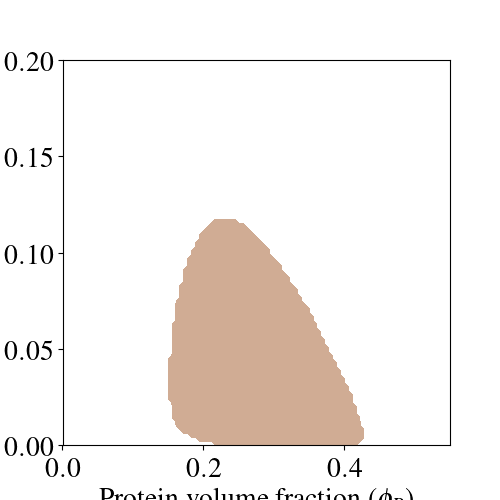

<IPython.core.display.Javascript object>


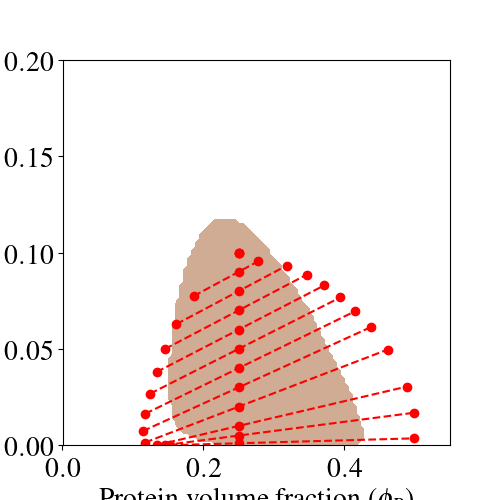

([0.25, 0.001, 0.0001], array([1.52181593e-01, 5.15313543e-08, 5.15313544e-09, 4.99308614e-01,
       3.54855681e-03, 3.54855682e-04, 7.18205726e-01]))
([0.25, 0.005, 0.0001], array([1.44960504e-01, 2.47557614e-06, 4.95115227e-08, 4.98715236e-01,
       1.68332676e-02, 3.36665353e-04, 7.03072535e-01]))
([0.25, 0.01, 0.0001], array([1.33674134e-01, 4.20579039e-05, 4.20579041e-07, 4.88664033e-01,
       3.04305603e-02, 3.04305605e-04, 6.72312181e-01]))
([0.25, 0.02, 0.0001], array([1.17202766e-01, 1.39016364e-03, 6.95081822e-06, 4.61553105e-01,
       4.96464659e-02, 2.48232330e-04, 6.14354282e-01]))
([0.25, 0.03, 0.0001], array([1.13796000e-01, 7.27636491e-03, 2.42545496e-05, 4.37267741e-01,
       6.12428696e-02, 2.04142899e-04, 5.78930761e-01]))
([0.25, 0.04, 0.0001], array([1.17418140e-01, 1.63098996e-02, 4.07747490e-05, 4.15694148e-01,
       6.96066973e-02, 1.74016743e-04, 5.55506120e-01]))
([0.25, 0.05, 0.0001], array([1.24251011e-01, 2.67281946e-02, 5.34563892e-05, 3.94282039e-01

<IPython.core.display.Javascript object>


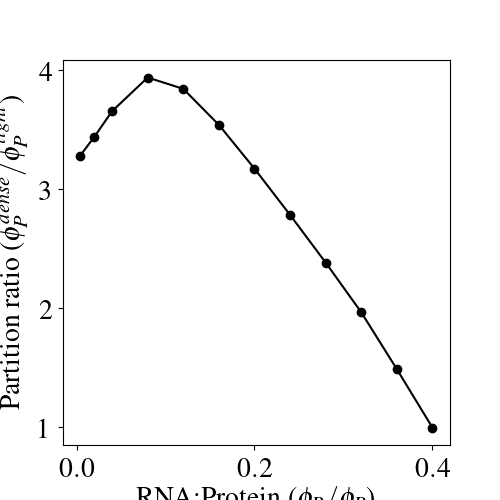

In [20]:
params = {
    'N_P': 5,
    'N_R': 50,
    'N_M': 50,
    'e_P': 2.2,
    'e_PM': 2.2,
    'e_PR': 2.2,
    'e_R': 2.0,
    }

fe_FH = free_energy_FH_3_comp(params)

analysis_FH = analyze_free_energies_3_comp(fe_FH)
num_points = {'P': 100, 'R': 100, 'M': 2}
ranges = {'P': [0.0001,0.55], 'M': [0.0001,0.2], 'R': [0.0001,0.2]}

x,y,z,u,v,w,stability = analysis_FH.get_instability(ranges=ranges, num_points=num_points)

fig = plt.figure(figsize=(5,5))
ax = fig.gca()
cmap = plt.cm.get_cmap("pink")

X,Y = np.meshgrid(x, y)
ax.contourf(X, Y, stability[:,:,0].transpose(), levels=[-1.0,0.0], cmap=cmap)
ax.set_xlim(ranges['P'])
ax.set_ylim(ranges['R'])
ax.set_xlabel(r'Protein volume fraction ($\phi_P$)')
ax.set_ylabel(r'RNA volume fraction ($\phi_R$)')

phi_r_list = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
list_of_points = [[0.25, phi, 0.0001] for phi in phi_r_list]
protein_partition_ratio = np.zeros(len(phi_r_list))

counter = 0

for conc_pt in list_of_points:
    
    if conc_pt[1] >= 0.09:
        initial_guess = [0.22, conc_pt[1]*0.95, 0.00005, 0.28, conc_pt[1]*1.05, 0.00015, 0.5]
        coexsitence_concs = analysis_FH.get_coexistence_concs(conc_pt[0], conc_pt[1], conc_pt[2], 
                                                              initial_guess)
    elif conc_pt[1] >= 0.03:
        initial_guess = [0.1, conc_pt[1]*0.5, 0.00005, 0.45, conc_pt[1]*1.5, 0.00015, 0.5]
        coexsitence_concs = analysis_FH.get_coexistence_concs(conc_pt[0], conc_pt[1], conc_pt[2], 
                                                              initial_guess)
    elif conc_pt[1] >= 0.02:
        initial_guess = [0.1, conc_pt[1]*0.95, 0.0001, 0.45, conc_pt[1]*1.05, 0.001, 0.5]
        coexsitence_concs = analysis_FH.get_coexistence_concs(conc_pt[0], conc_pt[1], conc_pt[2], 
                                                              initial_guess, enforce_log=1)
    elif conc_pt[1] >= 0.01:
        initial_guess = [0.15, conc_pt[1]*0.5, 0.0001, 0.45, conc_pt[1]*1.5, 0.0001, 0.7]
        coexsitence_concs = analysis_FH.get_coexistence_concs(conc_pt[0], conc_pt[1], conc_pt[2], 
                                                              initial_guess, enforce_log=1)
    elif conc_pt[1] < 0.01:
        initial_guess = [0.16, conc_pt[1]*0.5, 0.0001, 0.48, conc_pt[1]*1.5, 0.0001, 0.7]
        coexsitence_concs = analysis_FH.get_coexistence_concs(conc_pt[0], conc_pt[1], conc_pt[2], 
                                                              initial_guess, enforce_log=1)
    ax.plot([coexsitence_concs[0],conc_pt[0],coexsitence_concs[3]]
             ,[coexsitence_concs[1],conc_pt[1],coexsitence_concs[4]], '--ro')
    
    protein_partition_ratio[counter] = coexsitence_concs[3]/coexsitence_concs[0]
    counter = counter+1
    
    print(conc_pt, coexsitence_concs)

plt.savefig('Figures for paper/FH_2d_Phase_diagram.svg', format='svg', dpi=1200)    

fig,axs = plt.subplots(1,1,figsize=(5,5))
axs.plot(np.array(phi_r_list)/0.25, protein_partition_ratio,'-ko')
axs.set_xlabel(r'RNA:Protein ($\phi_R/\phi_P$)')
axs.set_ylabel(r'Partition ratio ($\phi^{dense}_P/\phi^{light}_P$)')
plt.savefig('Figures for paper/FH_1d_Phase_diagram_phi_p0_pt25.svg', format='svg', dpi=1200)

# Analysis of Modified Flory Huggins

In [8]:
params = {
    'N_P': 5,
    'N_R': 50,
    'N_M': 50,
    'chi_P': 1.1,
    'chi_PM': 1.2,
    'chi_PR': 1.2,
    'rho_R': 2.0,
    }
fe_FH_mod = free_energy_FH_mod_3_comp(params)
analysis_FH_mod = analyze_free_energies_3_comp(fe_FH_mod)

In [9]:
list_of_phi_r_list = list()
list_of_protein_partition_ratios = list()

<IPython.core.display.Javascript object>


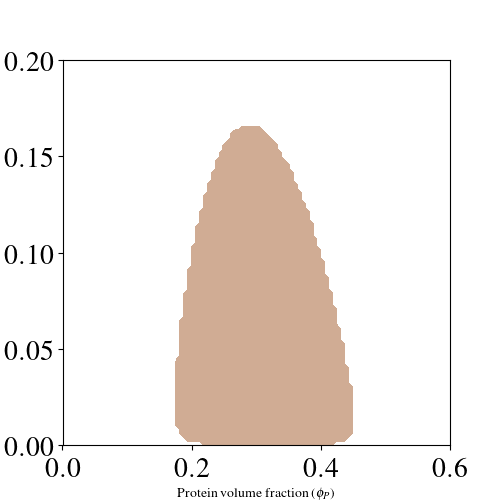

<IPython.core.display.Javascript object>


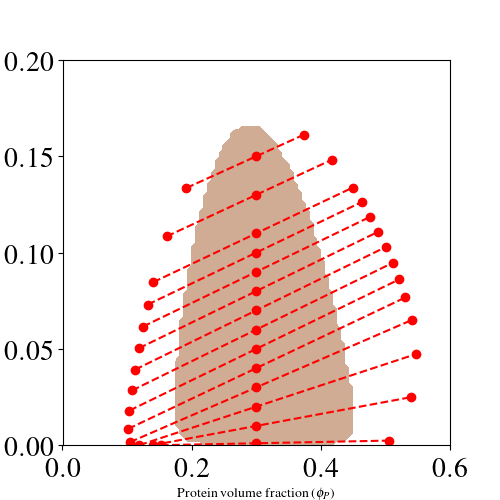

/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log


<IPython.core.display.Javascript object>


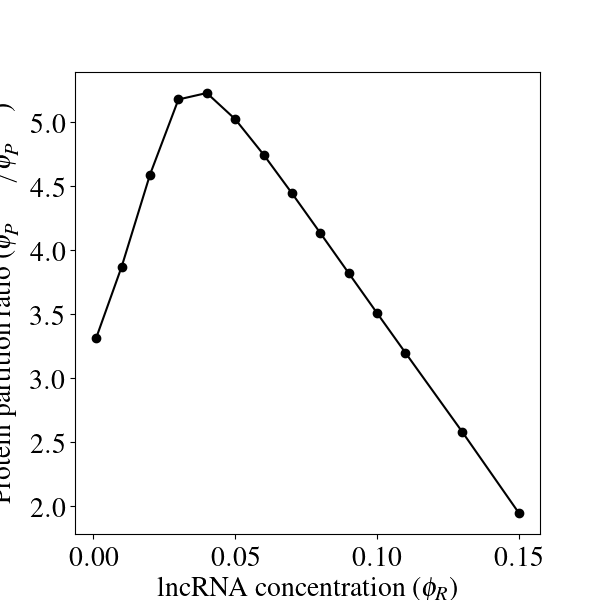

In [13]:
# Phase diagram at low phi_m:
phi_m = 0.0001
num_points = {'P': 100, 'R': 100, 'M': 2}
ranges = {'P': [0.0001,0.6], 'R': [0.0001,0.2], 'M': [phi_m,0.15]}
x,y,z,u,v,w,stability = analysis_FH_mod.get_instability(ranges=ranges, num_points=num_points)

fig = plt.figure(figsize=(5,5))
ax = fig.gca()
cmap = plt.cm.get_cmap("pink")

X,Y = np.meshgrid(x, y)
ax.contourf(X, Y, stability[:,:,0].transpose(), levels=[-1.0,0.0], cmap=cmap)
ax.set_xlim(ranges['P'])
ax.set_ylim(ranges['R'])
ax.set_xlabel(r'Protein volume fraction ($\phi_P$)')
ax.set_ylabel(r'RNA volume fraction ($\phi_R$)')

phi_r_list = [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.13, 0.15]
list_of_points = [[0.3, phi, 0.0001] for phi in phi_r_list]
protein_partition_ratio = np.zeros(len(phi_r_list))

counter = 0
for conc_pt in list_of_points:    
    if conc_pt[1] > 0.13:
        initial_guess = [0.2, conc_pt[1]*0.5, phi_m*0.5, 0.4, conc_pt[1]*1.5, phi_m*1.5, 0.5]
        coexsitence_concs = analysis_FH_mod.get_coexistence_concs(conc_pt[0], conc_pt[1], conc_pt[2], 
                                                              initial_guess, enforce_log=1)
    elif conc_pt[1] >= 0.001:
        initial_guess = [0.1, conc_pt[1]*0.5, phi_m*0.5, 0.55, conc_pt[1]*1.5, phi_m*1.5, 0.5]
        coexsitence_concs = analysis_FH_mod.get_coexistence_concs(conc_pt[0], conc_pt[1], conc_pt[2], 
                                                              initial_guess, enforce_log=1)
    plt.plot([coexsitence_concs[0],conc_pt[0],coexsitence_concs[3]]
             ,[coexsitence_concs[1],conc_pt[1],coexsitence_concs[4]], '--ro')
    protein_partition_ratio[counter] = coexsitence_concs[3]/coexsitence_concs[0]
    counter = counter+1

plt.savefig('Figures for paper/modified_FH_2d_Phase_diagram_phi_m_pt0001.svg', format='svg', dpi=1200)  

fig,axs = plt.subplots(1,1,figsize=(6,6))
plt.plot(np.array(phi_r_list), protein_partition_ratio,'-ko')
axs.set_xlabel(r'lncRNA concentration ($\phi_R$)', fontsize=20)
axs.set_ylabel(r'Protein partition ratio ($\phi^{dense}_P/\phi^{light}_P$)', fontsize=20)
plt.savefig('Figures for paper/modified_FH_1d_Phase_diagram_phi_m_pt0001.svg', format='svg', dpi=1200)

list_of_phi_r_list.append(phi_r_list)
list_of_protein_partition_ratios.append(protein_partition_ratio)

<IPython.core.display.Javascript object>


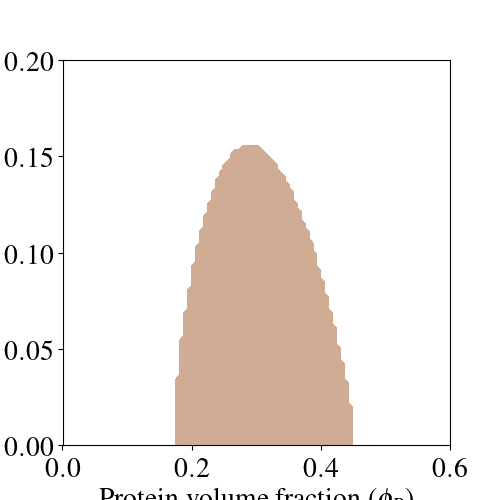

<IPython.core.display.Javascript object>


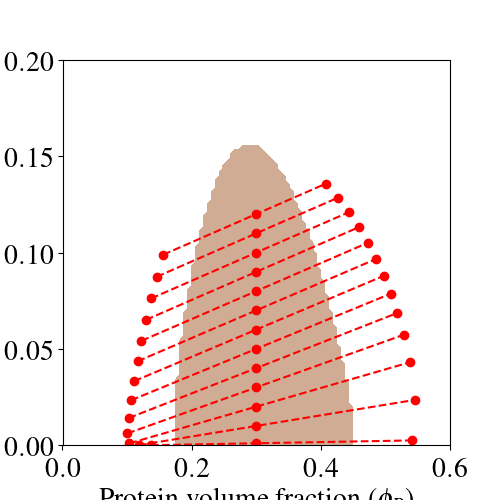

<IPython.core.display.Javascript object>


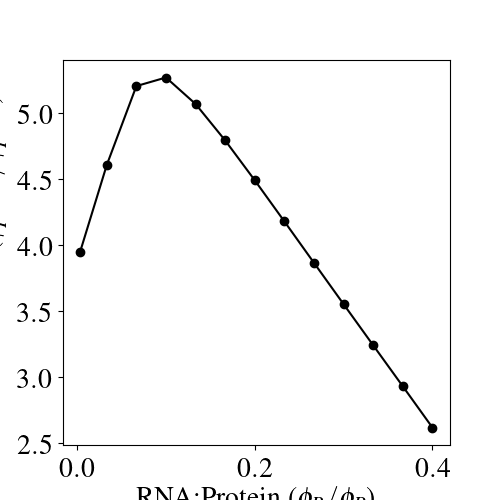

In [29]:
# Phase diagram at moderate phi_m:
phi_m = 0.01
num_points = {'P': 100, 'R': 100, 'M': 2}
ranges = {'P': [0.0001,0.6], 'R': [0.0001,0.2], 'M': [phi_m,0.15]}
x,y,z,u,v,w,stability = analysis_FH_mod.get_instability(ranges=ranges, num_points=num_points)


fig = plt.figure(figsize=(5,5))
ax = fig.gca()
cmap = plt.cm.get_cmap("pink")

X,Y = np.meshgrid(x, y)
ax.contourf(X, Y, stability[:,:,0].transpose(), levels=[-1.0,0.0], cmap=cmap)
ax.set_xlim(ranges['P'])
ax.set_ylim(ranges['R'])
ax.set_xlabel(r'Protein volume fraction ($\phi_P$)')
ax.set_ylabel(r'RNA volume fraction ($\phi_R$)')

phi_r_list = [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12]
list_of_points = [[0.3, phi, phi_m] for phi in phi_r_list]
protein_partition_ratio = np.zeros(len(phi_r_list))
counter = 0
for conc_pt in list_of_points:
    
    if conc_pt[1] >= 0.001:
        initial_guess = [0.1, conc_pt[1]*0.5, phi_m*0.95, 0.6, conc_pt[1]*1.05, phi_m*1.5, 0.5]
        coexsitence_concs = analysis_FH_mod.get_coexistence_concs(conc_pt[0], conc_pt[1], conc_pt[2], 
                                                              initial_guess, enforce_log=1)
    elif conc_pt[1] >= 0.01:
        initial_guess = [0.1, conc_pt[1]*0.5, phi_m*0.8, 0.5, conc_pt[1]*1.5, phi_m*1.2, 0.5]
        coexsitence_concs = analysis_FH_mod.get_coexistence_concs(conc_pt[0], conc_pt[1], conc_pt[2], 
                                                              initial_guess, enforce_log=1)
    elif conc_pt[1] >= 0.04:
        initial_guess = [0.1, conc_pt[1]*0.5, phi_m*0.5, 0.5, conc_pt[1]*1.5, phi_m*1.5, 0.5]
        coexsitence_concs = analysis_FH_mod.get_coexistence_concs(conc_pt[0], conc_pt[1], conc_pt[2], 
                                                              initial_guess, enforce_log=1)
    elif conc_pt[1] >= 0.13: 
        initial_guess = [0.15, conc_pt[1]*0.8, phi_m*0.95, 0.45, conc_pt[1]*1.2, phi_m*1.05, 0.1]
        coexsitence_concs = analysis_FH_mod.get_coexistence_concs(conc_pt[0], conc_pt[1], conc_pt[2], 
                                                              initial_guess)
    
    # coexsitence_concs = analysis_FH_mod.get_coexistence_concs(conc_pt[0], conc_pt[1], conc_pt[2], 
                                                              # initial_guess, enforce_log=1)
    plt.plot([coexsitence_concs[0],conc_pt[0],coexsitence_concs[3]]
             ,[coexsitence_concs[1],conc_pt[1],coexsitence_concs[4]], '--ro')
    protein_partition_ratio[counter] = coexsitence_concs[3]/coexsitence_concs[0]
    counter = counter+1

plt.savefig('Figures for paper/modified_FH_2d_Phase_diagram_phi_m_pt01.svg', format='svg', dpi=1200)  

fig,axs = plt.subplots(1,1,figsize=(5,5))
plt.plot(np.array(phi_r_list)/0.3, protein_partition_ratio,'-ko')
axs.set_xlabel(r'RNA:Protein ($\phi_R/\phi_P$)')
axs.set_ylabel(r'Partition ratio ($\phi^{dense}_P/\phi^{light}_P$)')
plt.savefig('Figures for paper/modified_FH_1d_Phase_diagram_phi_m_pt01.svg', format='svg', dpi=1200)

list_of_phi_r_list.append(phi_r_list)
list_of_protein_partition_ratios.append(protein_partition_ratio)

<IPython.core.display.Javascript object>


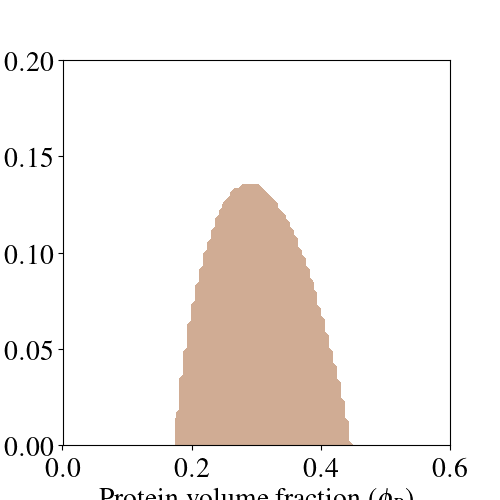

<IPython.core.display.Javascript object>


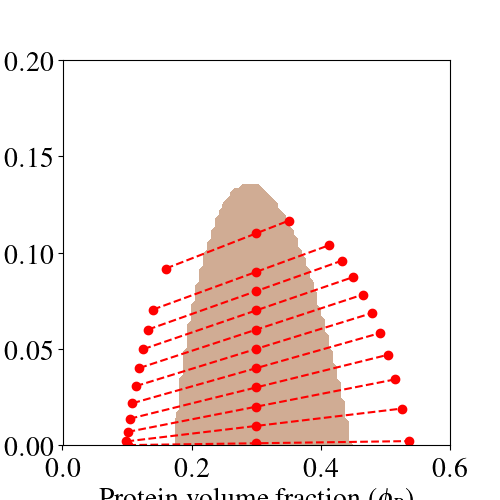

<IPython.core.display.Javascript object>


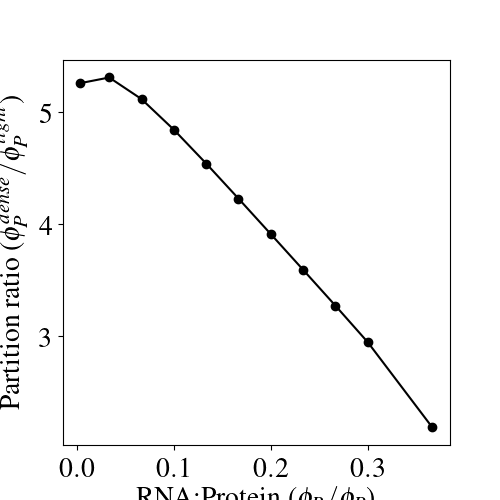

In [30]:
# Phase diagram at moderate phi_m:
phi_m = 0.03
num_points = {'P': 100, 'R': 100, 'M': 2}
ranges = {'P': [0.0001,0.6], 'R': [0.0001,0.2], 'M': [phi_m,0.15]}
x,y,z,u,v,w,stability = analysis_FH_mod.get_instability(ranges=ranges, num_points=num_points)

fig = plt.figure(figsize=(5,5))
ax = fig.gca()
cmap = plt.cm.get_cmap("pink")

X,Y = np.meshgrid(x, y)
ax.contourf(X, Y, stability[:,:,0].transpose(), levels=[-1.0,0.0], cmap=cmap)
ax.set_xlim(ranges['P'])
ax.set_ylim(ranges['R'])
ax.set_xlabel(r'Protein volume fraction ($\phi_P$)')
ax.set_ylabel(r'RNA volume fraction ($\phi_R$)')

phi_r_list = [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.11]
list_of_points = [[0.3, phi, phi_m] for phi in phi_r_list]
protein_partition_ratio = np.zeros(len(phi_r_list))
counter = 0
for conc_pt in list_of_points:
    if conc_pt[1] >= 0.001:
        initial_guess = [0.1, conc_pt[1]*0.5, phi_m*0.95, 0.6, conc_pt[1]*1.05, phi_m*1.5, 0.5]
        coexsitence_concs = analysis_FH_mod.get_coexistence_concs(conc_pt[0], conc_pt[1], conc_pt[2], 
                                                              initial_guess, enforce_log=1)
    elif conc_pt[1] >=0.01:
        initial_guess = [0.1, conc_pt[1]*0.5, phi_m*0.5, 0.53, conc_pt[1]*1.5, phi_m*0.5, 0.5]
        coexsitence_concs = analysis_FH_mod.get_coexistence_concs(conc_pt[0], conc_pt[1], conc_pt[2], 
                                                              initial_guess, enforce_log=1)
    plt.plot([coexsitence_concs[0],conc_pt[0],coexsitence_concs[3]]
             ,[coexsitence_concs[1],conc_pt[1],coexsitence_concs[4]], '--ro')
    protein_partition_ratio[counter] = coexsitence_concs[3]/coexsitence_concs[0]
    counter = counter+1
    
plt.savefig('Figures for paper/modified_FH_2d_Phase_diagram_phi_m_pt03.svg', format='svg', dpi=1200)  

fig,axs = plt.subplots(1,1,figsize=(5,5))
plt.plot(np.array(phi_r_list)/0.3, protein_partition_ratio,'-ko')
axs.set_xlabel(r'RNA:Protein ($\phi_R/\phi_P$)')
axs.set_ylabel(r'Partition ratio ($\phi^{dense}_P/\phi^{light}_P$)')
plt.savefig('Figures for paper/modified_FH_1d_Phase_diagram_phi_m_pt03.svg', format='svg', dpi=1200)

list_of_phi_r_list.append(phi_r_list)
list_of_protein_partition_ratios.append(protein_partition_ratio)

<IPython.core.display.Javascript object>


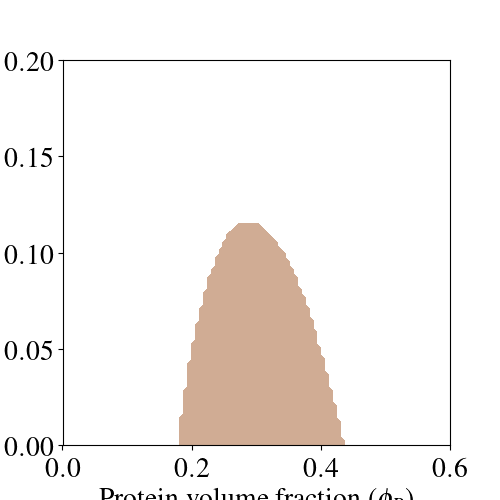

<IPython.core.display.Javascript object>


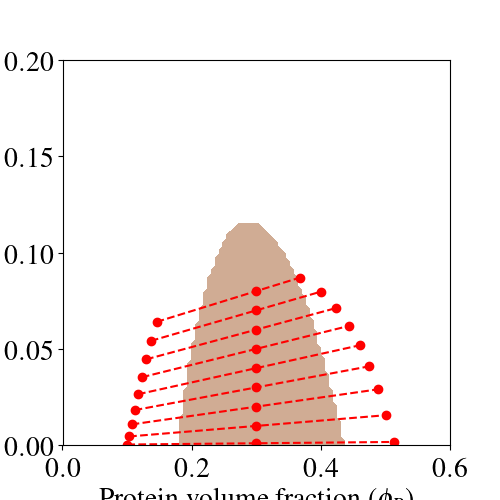

<IPython.core.display.Javascript object>


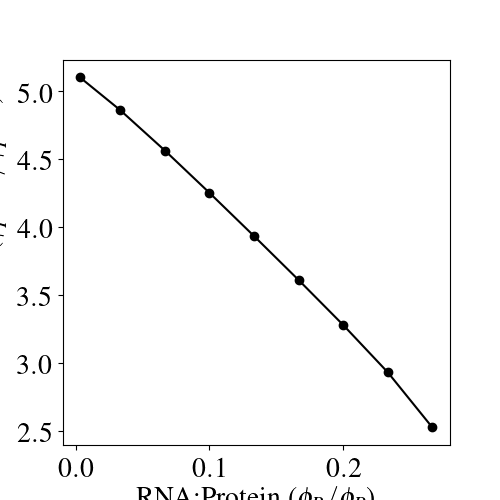

In [31]:
# Phase diagram at moderate phi_m:
phi_m = 0.05
num_points = {'P': 100, 'R': 100, 'M': 2}
ranges = {'P': [0.0001,0.6], 'R': [0.0001,0.2], 'M': [phi_m,0.15]}
x,y,z,u,v,w,stability = analysis_FH_mod.get_instability(ranges=ranges, num_points=num_points)

fig = plt.figure(figsize=(5,5))
ax = fig.gca()
cmap = plt.cm.get_cmap("pink")

X,Y = np.meshgrid(x, y)
ax.contourf(X, Y, stability[:,:,0].transpose(), levels=[-1.0,0.0], cmap=cmap)
ax.set_xlim(ranges['P'])
ax.set_ylim(ranges['R'])
ax.set_xlabel(r'Protein volume fraction ($\phi_P$)')
ax.set_ylabel(r'RNA volume fraction ($\phi_R$)')

phi_r_list = [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
list_of_points = [[0.3, phi, phi_m] for phi in phi_r_list]
protein_partition_ratio = np.zeros(len(phi_r_list))
counter = 0
for conc_pt in list_of_points:
    if conc_pt[1] >=0.001:
        initial_guess = [0.1, conc_pt[1]*0.5, phi_m*0.5, 0.5, conc_pt[1]*1.5, phi_m*1.5, 0.5] 
    elif conc_pt[1] >= 0.09:
        initial_guess = [0.1, conc_pt[1]*0.5, phi_m*0.5, 0.4, conc_pt[1]*1.5, phi_m*1.5, 0.5] 
    coexsitence_concs = analysis_FH_mod.get_coexistence_concs(conc_pt[0], conc_pt[1], conc_pt[2], 
                                                              initial_guess, enforce_log=1)
    plt.plot([coexsitence_concs[0],conc_pt[0],coexsitence_concs[3]]
             ,[coexsitence_concs[1],conc_pt[1],coexsitence_concs[4]], '--ro')
    protein_partition_ratio[counter] = coexsitence_concs[3]/coexsitence_concs[0]
    counter = counter + 1
    
plt.savefig('Figures for paper/modified_FH_2d_Phase_diagram_phi_m_pt05.svg', format='svg', dpi=1200)  

fig,axs = plt.subplots(1,1,figsize=(5,5))
plt.plot(np.array(phi_r_list)/0.3, protein_partition_ratio,'-ko')
axs.set_xlabel(r'RNA:Protein ($\phi_R/\phi_P$)')
axs.set_ylabel(r'Partition ratio ($\phi^{dense}_P/\phi^{light}_P$)')
plt.savefig('Figures for paper/modified_FH_1d_Phase_diagram_phi_m_pt05.svg', format='svg', dpi=1200)

list_of_phi_r_list.append(phi_r_list)
list_of_protein_partition_ratios.append(protein_partition_ratio)

<IPython.core.display.Javascript object>


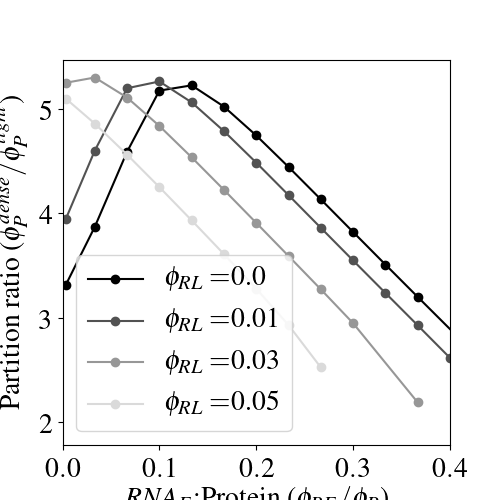

In [32]:
fig,axs = plt.subplots(1,1,figsize=(5,5))
labels = [0.0, 0.01, 0.03, 0.05]
colors = plt.cm.get_cmap("Greys_r") 
vals = np.linspace(0.0,0.75,len(list_of_phi_r_list))
for i in range(len(list_of_phi_r_list)):
    axs.plot(np.array(list_of_phi_r_list[i])/0.3, list_of_protein_partition_ratios[i],'-o',c=colors(vals[i]),
             label=r'$\phi_{RL}=$' + str(labels[i]))
axs.set_xlabel(r'$RNA_E$:Protein ($\phi_{RE}/\phi_P$)')
axs.set_ylabel(r'Partition ratio ($\phi^{dense}_P/\phi^{light}_P$)')
axs.set_xlim([0.0, 0.4])
axs.legend()
plt.savefig('Figures for paper/modified_FH_1d_Phase_diagram_all_phi_m.svg', format='svg', dpi=1200)

<IPython.core.display.Javascript object>


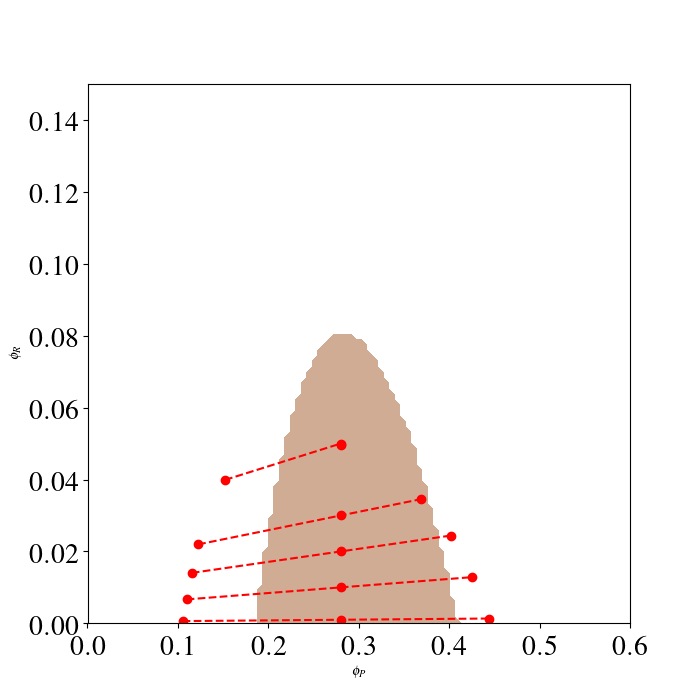

In [87]:
# Phase diagram at moderate phi_m:
phi_m = 0.1
num_points = {'P': 100, 'R': 100, 'M': 2}
ranges = {'P': [0.0001,0.6], 'R': [0.0001,0.15], 'M': [phi_m,0.15]}
x,y,z,u,v,w,stability = analysis_FH_mod.get_instability(ranges=ranges, num_points=num_points)
phi_r_list = [0.001,0.01, 0.02, 0.03, 0.05]
list_of_points = [[0.28, phi, phi_m] for phi in phi_r_list]
for conc_pt in list_of_points:
    initial_guess = [0.1, conc_pt[1]*0.5, phi_m*0.5, 0.42, conc_pt[1]*1.5, phi_m*1.5, 0.5]
    coexsitence_concs = analysis_FH_mod.get_coexistence_concs(conc_pt[0], conc_pt[1], conc_pt[2], 
                                                              initial_guess, enforce_log=1)
    plt.plot([coexsitence_concs[0],conc_pt[0],coexsitence_concs[3]]
             ,[coexsitence_concs[1],conc_pt[1],coexsitence_concs[4]], '--ro')

## Landau series expansion

<IPython.core.display.Javascript object>


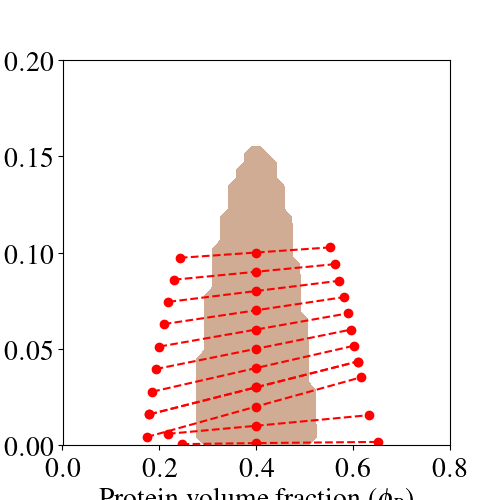

([0.4, 0.001, 1e-05], array([ 2.45880977e-01,  4.53117973e-04,  7.54636680e-04,  6.50608091e-01,
        1.61660693e-03, -6.28171828e-05,  5.33652287e-01]))
([0.4, 0.01, 1e-05], array([ 2.17679347e-01,  5.82362077e-03,  6.02827975e-04,  6.33554531e-01,
        1.55416553e-02, -4.51821486e-05,  4.54256412e-01]))
([0.4, 0.02, 1e-05], array([1.73668347e-01, 4.11641287e-03, 9.99999540e-06, 6.15265749e-01,
       3.51070000e-02, 1.00000045e-05, 4.87470597e-01]))
([0.4, 0.03, 1e-05], array([1.79082097e-01, 1.59110608e-02, 9.99999994e-06, 6.09273269e-01,
       4.33463079e-02, 9.99999994e-06, 4.86465745e-01]))
([0.4, 0.03, 1e-05], array([1.79082097e-01, 1.59110608e-02, 9.99999994e-06, 6.09273269e-01,
       4.33463079e-02, 9.99999994e-06, 4.86465745e-01]))
([0.4, 0.04, 1e-05], array([1.85242990e-01, 2.76870246e-02, 1.00000097e-05, 6.02857904e-01,
       5.16307467e-02, 1.00000130e-05, 4.85753494e-01]))
([0.4, 0.05, 1e-05], array([1.92208325e-01, 3.94337187e-02, 9.99999939e-06, 5.95969143e-01,

<IPython.core.display.Javascript object>


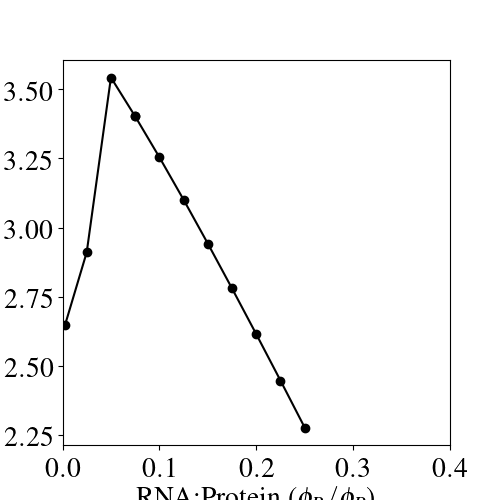

In [11]:
phi_m = 0.00001
params = {
    'rho_p': 3,
    'alpha': 0.2,
    'beta': 0.6,
    'rho_r': 10.0,
    'chi_pm': 2,
    'chi_pr': 2,
    'a': 0.0,
    'b': 0.0,
    'c': 10.0,
    'wall_k': 1e9,
    'neg_max':0.0001
    }

fe_landau = free_energy_landau_3_comp(params)

analysis_landau = analyze_free_energies_3_comp(fe_landau)
num_points = {'P': 50, 'R': 50, 'M': 2}
ranges = {'P': [0.0001,0.8], 'M': [phi_m,0.2], 'R': [0.00001,0.2]}

x,y,z,u,v,w,stability = analysis_landau.get_instability(ranges=ranges, num_points=num_points)

phi_r_list = [0.001, 0.01, 0.02, 0.03, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
list_of_points = [[0.4, phi, phi_m] for phi in phi_r_list]
protein_partition_ratio = np.zeros(len(phi_r_list))

# list_of_points = [[0.4, 0.001, phi_m],
#                   [0.4, 0.01, phi_m],
#                   [0.4, 0.03, phi_m],
#                   [0.4, 0.04, phi_m],
#                   [0.4, 0.05, phi_m],
#                   [0.4, 0.06, phi_m],
#                   [0.4, 0.07, phi_m],
#                   [0.4, 0.08, phi_m],
#                   [0.4, 0.09, phi_m],
#                   [0.4, 0.11, phi_m]]
counter= 0
for conc_pt in list_of_points:
    
    if conc_pt[1] >= 0.001:
        initial_guess = [0.19, conc_pt[1]*0.5, 0.5*phi_m, 0.61, conc_pt[1]*1.5, phi_m*1.5, 0.1]
    elif conc_pt[1] >= 0.03:
        initial_guess = [0.15, conc_pt[1]*0.5, 0.5*phi_m, 0.6, conc_pt[1]*1.5, phi_m*1.5, 0.5]
    elif conc_pt[1] >= 0.12:
        initial_guess = [0.2, conc_pt[1]*1.5, 0.5*phi_m, 0.6, conc_pt[1]*0.5, phi_m*1.5, 0.8]
        
    
    coexsitence_concs = analysis_landau.get_coexistence_concs(conc_pt[0], conc_pt[1], conc_pt[2], 
                                                              initial_guess)
    
    print(conc_pt, coexsitence_concs)
    plt.plot([coexsitence_concs[0],conc_pt[0],coexsitence_concs[3]]
             ,[coexsitence_concs[1],conc_pt[1],coexsitence_concs[4]], '--ro')
    protein_partition_ratio[counter] = coexsitence_concs[3]/coexsitence_concs[0]
    counter = counter+1
    
plt.savefig('Figures for paper/landau_2d_Phase_diagram.svg', format='svg', dpi=1200)  

fig,axs = plt.subplots(1,1,figsize=(5,5))
plt.plot(np.array(phi_r_list)/0.4, protein_partition_ratio,'-ko')
axs.set_xlabel(r'RNA:Protein ($\phi_R/\phi_P$)')
axs.set_ylabel(r'Partition ratio ($\phi^{dense}_P/\phi^{light}_P$)')
axs.set_xlim([0.0,0.4])
# axs.set_ylim([1.8,5.2])
plt.savefig('Figures for paper/landau_1d_Phase_diagram.svg', format='svg', dpi=1200)

<IPython.core.display.Javascript object>


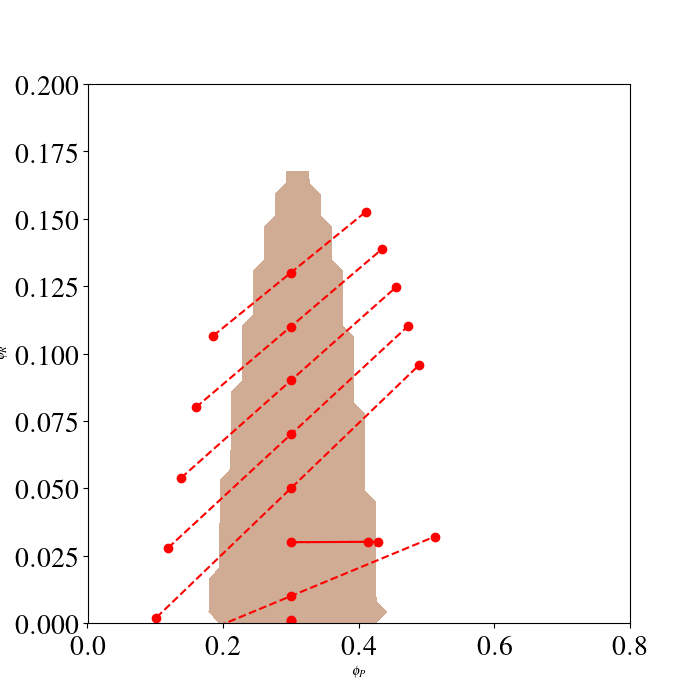

([0.3, 0.001, 1e-05], array([ 3.00135772e-01,  7.37818192e-04,  3.06346874e-04,  3.00135361e-01,
        7.38612199e-04,  3.05449431e-04, -3.29200387e+02]))
([0.3, 0.01, 1e-05], array([ 0.1478476 , -0.00583956, -0.00583956,  0.51192626,  0.03206222,
        0.00815759,  0.58208921]))
([0.3, 0.03, 1e-05], array([0.41430027, 0.03012112, 0.02152634, 0.42807365, 0.03013572,
       0.02411911, 9.29863582]))
([0.3, 0.05, 1e-05], array([1.01730840e-01, 2.03695533e-03, 1.00000207e-05, 4.88503618e-01,
       9.56006745e-02, 9.99997714e-06, 4.87375608e-01]))
([0.3, 0.07, 1e-05], array([1.18889346e-01, 2.78643209e-02, 1.00000000e-05, 4.72625372e-01,
       1.10161565e-01, 1.00000000e-05, 4.88006194e-01]))
([0.3, 0.09, 1e-05], array([1.37964516e-01, 5.38122034e-02, 1.00000000e-05, 4.54930158e-01,
       1.24600946e-01, 9.99999999e-06, 4.88791647e-01]))
([0.3, 0.11, 1e-05], array([1.59699102e-01, 7.99825959e-02, 1.00000000e-05, 4.34676219e-01,
       1.38814003e-01, 1.00000000e-05, 4.89772460e-01])

In [356]:
phi_m = 0.00001
params = {
    'rho_p': 1.5,
    'alpha': 0.2,
    'beta': 0.45,
    'rho_r': 1.5,
    'chi_pm': 1.2,
    'chi_pr': 1.2,
    'a': 0.5,
    'b': 0.5,
    'c': 0.5,
    'wall_k': 1e5,
    'neg_max':0.001
    }

fe_landau = free_energy_landau_3_comp(params)

analysis_landau = analyze_free_energies_3_comp(fe_landau)
num_points = {'P': 50, 'R': 50, 'M': 2}
ranges = {'P': [0.0001,0.8], 'M': [phi_m,0.2], 'R': [0.00001,0.2]}

x,y,z,u,v,w,stability = analysis_landau.get_instability(ranges=ranges, num_points=num_points)

list_of_points = [[0.3, 0.001, phi_m],
                  [0.3, 0.01, phi_m],
                  [0.3, 0.03, phi_m],
                  [0.3, 0.05, phi_m],
                  [0.3, 0.07, phi_m],
                  [0.3, 0.09, phi_m],
                  [0.3, 0.11, phi_m],
                  [0.3, 0.13, phi_m]]

for conc_pt in list_of_points:
    
    initial_guess = [0.15, conc_pt[1]*0.5, 0.5*phi_m, 0.5, conc_pt[1]*1.5, phi_m*1.5, 0.1]
    
    coexsitence_concs = analysis_landau.get_coexistence_concs(conc_pt[0], conc_pt[1], conc_pt[2], 
                                                              initial_guess)
    
    print(conc_pt, coexsitence_concs)
    plt.plot([coexsitence_concs[0],conc_pt[0],coexsitence_concs[3]]
             ,[coexsitence_concs[1],conc_pt[1],coexsitence_concs[4]], '--ro')